# Microfinance analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [2]:
import pickle

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate, find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

# Read data

In [77]:
df = pd.read_csv("../Data/banerjee_miracle.csv")

df.head()

,hhid,areaid,treatment,hh_edu,hh_gender,old_biz,area_pop_base,area_debt_total_base,area_business_total_base,area_exp_pc_mean_base,...,informal_amt_2,female_biz_pct_2,hours_week_2,durables_exp_mo_2,temptation_exp_mo_2,total_exp_mo_2,bizprofit_2,bizrev_2,bizemployees_2,girls_school_2
0,1,1,1,1.0,1.0,0.0,1,3,2,3,...,0.000000,NaN,84.0,138.82982,0.0000,4128.3823,0.0000,0.0000,0.0,1.0
1,2,1,1,0.0,1.0,0.0,1,3,2,3,...,0.000000,NaN,126.0,793.41240,533.1065,6835.4253,0.0000,0.0000,0.0,1.0
2,3,1,1,0.0,1.0,1.0,1,3,2,3,...,0.000000,0.0,36.0,1291.11730,0.0000,11836.0750,2049.1282,2498.9368,0.0,NaN
3,4,1,1,0.0,1.0,1.0,1,3,2,3,...,462303.305354,1.0,84.0,347.07455,0.0000,8740.4480,2082.4473,2498.9368,1.0,1.0
4,5,1,1,0.0,1.0,1.0,1,3,2,3,...,45813.841071,0.0,63.0,104.12237,0.0000,6607.4670,NaN,74634.0800,0.0,NaN


In [78]:
cols = df.columns
outcome_cols = cols[12:]

print(outcome_cols)

Index(['anyloan_amt_2', 'informal_amt_2', 'female_biz_pct_2', 'hours_week_2',
       'durables_exp_mo_2', 'temptation_exp_mo_2', 'total_exp_mo_2',
       'bizprofit_2', 'bizrev_2', 'bizemployees_2', 'girls_school_2'],
      dtype='object')


In [79]:
covariate_cols_id = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
covariate_cols = [cols[x] for x in covariate_cols_id]

print(covariate_cols)

['treatment', 'hh_edu', 'hh_gender', 'old_biz', 'area_pop_base', 'area_debt_total_base', 'area_business_total_base', 'area_exp_pc_mean_base', 'area_literate_head_base', 'area_literate_base']


In [80]:
df["treatment"] = df["treatment"] + 1
df["hh_edu"] = df["hh_edu"] + 1
df["hh_gender"] = df["hh_gender"] + 1

In [81]:
outcome_col_id = 12
outcome_col = cols[outcome_col_id]

chosen_covariates_idx = [2, 3, 4, 5, 7, 8]
chosen_covariates = [cols[x] for x in chosen_covariates_idx]

print(f"Covariates used are {chosen_covariates}")
print(f"Outcome is {outcome_col}")

df2 = df.copy()
df2 = df2.dropna(subset=[outcome_col], axis=0)

Z = df2.to_numpy()

X = Z[:, chosen_covariates_idx]
y = Z[:, outcome_col_id]
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

Covariates used are ['treatment', 'hh_edu', 'hh_gender', 'old_biz', 'area_debt_total_base', 'area_business_total_base']
Outcome is anyloan_amt_2
There are 6142 data points


In [82]:
pd.unique(df2[outcome_col])

array([ 11000.,  25000.,   5000., ..., 110720., 134510.,  26050.])

# Analysis

In [83]:
M = 6
R = np.array([3, 3, 3, 4, 4, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [84]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [85]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

0.21031746031746032


(array([1424]),)

In [ ]:
reg = 1e-4

# With q = 6.8e-3, we got
# Best model loss 0.006677662589304398 and epsilon 0.0149752999141002
# Smallest model 32.0, largest model 49.0
# And there were 4227072 models

q =  4.6e-3

# H = 20
H = np.inf
R_set, R_profiles = RAggregate(M, R, H, D, y, q, reg=reg)
# R_set, R_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

Skipping profile (0, 0, 0, 0, 0, 0)
Skipping profile (0, 0, 0, 0, 0, 1)
Skipping profile (0, 0, 0, 0, 1, 0)
Skipping profile (0, 0, 0, 0, 1, 1)
Skipping profile (0, 0, 0, 1, 0, 0)
Skipping profile (0, 0, 0, 1, 0, 1)
Skipping profile (0, 0, 0, 1, 1, 0)
Skipping profile (0, 0, 0, 1, 1, 1)
Skipping profile (0, 0, 1, 0, 0, 0)
Skipping profile (0, 0, 1, 0, 0, 1)
Skipping profile (0, 0, 1, 0, 1, 0)
Skipping profile (0, 0, 1, 0, 1, 1)
Skipping profile (0, 0, 1, 1, 0, 0)
Skipping profile (0, 0, 1, 1, 0, 1)
Skipping profile (0, 0, 1, 1, 1, 0)
Skipping profile (0, 0, 1, 1, 1, 1)
Skipping profile (0, 1, 0, 0, 0, 0)
Skipping profile (0, 1, 0, 0, 0, 1)
Skipping profile (0, 1, 0, 0, 1, 0)
Skipping profile (0, 1, 0, 0, 1, 1)
Skipping profile (0, 1, 0, 1, 0, 0)
Skipping profile (0, 1, 0, 1, 0, 1)
Skipping profile (0, 1, 0, 1, 1, 0)
Skipping profile (0, 1, 0, 1, 1, 1)
Skipping profile (0, 1, 1, 0, 0, 0)
Skipping profile (0, 1, 1, 0, 0, 1)
Skipping profile (0, 1, 1, 0, 1, 0)
Skipping profile (0, 1, 1, 0

In [95]:

R_set = find_feasible_combinations(R_profiles, 4.6e-3, np.inf, sorted=True)
print(len(R_set))

13333


In [96]:
model_losses = []
model_sizes = []

for r_set in R_set:
    loss_r = 0
    size_r = 0
    for profile, model_prof in enumerate(r_set):
        loss_r_prof = R_profiles[profile].loss[model_prof]
        size_r_prof = R_profiles[profile].pools[model_prof]
        loss_r += loss_r_prof
        size_r += size_r_prof
    
    model_losses.append(loss_r)
    model_sizes.append(size_r)

q0 = np.min(model_losses)
eps = (np.max(model_losses) - np.min(model_losses)) / q0

print(f"Best model loss {q0} and epsilon {eps}")

print(f"Smallest model {np.min(model_sizes)}, largest model {np.max(model_sizes)}")

Best model loss 0.004299737679159057 and epsilon 0.06977152970196171
Smallest model 64.0, largest model 67.0


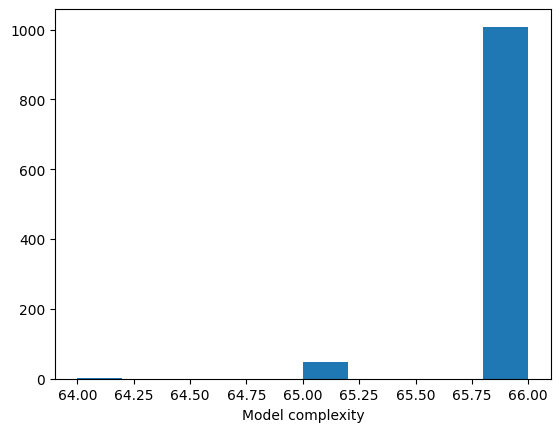

In [91]:
plt.hist(model_sizes)

plt.xlabel("Model complexity")

plt.show()

In [517]:
res_dict = {
    "outcome": outcome_col,
    "reg": reg,
    "q": q,
    "q0": q0,
    "eps": eps,
    "H": H,
    "R_set": R_set,
    "R_profiles": R_profiles
}

In [518]:
pkl_fname = "../Results/microfinance/" + outcome_col + ".pkl"

with open(pkl_fname, "wb") as f:
    pickle.dump(res_dict, f, pickle.HIGHEST_PROTOCOL)

print("Done pickling!")

Done pickling!


## Plots

In [265]:
results_dir = "../Results/microfinance/"
# outcome_str = "durables_exp_mo_2"
outcome_str = outcome_col

outcome_fname = results_dir + outcome_str + ".pkl"

In [266]:
with open(outcome_fname, "rb") as f:
    res_dict = pickle.load(f)

reg = res_dict["reg"]
q = res_dict["q"]
q0 = res_dict["q0"]
eps = res_dict["eps"]
H = res_dict["H"]
R_set = res_dict["R_set"]
R_profiles = res_dict["R_profiles"]

print(reg, q, q0, eps)

1e-06 1e-05 4.9999999999999996e-06 1.0000000000000004


In [538]:
# Find active profiles

for k, R_profile in enumerate(R_profiles):
    if len(R_profile) == 1:
        if R_profile.sigma[0] is None:
            continue

    if profiles[k][-1] == 0:
        continue
    print(k, profiles[k]) #, R_profile.sigma[0].shape)
    for sigma in R_profile.sigma:
        sigma_temp = sigma.copy()
        sigma_temp[np.isinf(sigma_temp)] = 1
        if np.all(np.equal(sigma_temp, 1)):
            print("Flat!")

51 (1, 1, 0, 0, 1, 1)
Flat!
53 (1, 1, 0, 1, 0, 1)
Flat!
55 (1, 1, 0, 1, 1, 1)
Flat!
63 (1, 1, 1, 1, 1, 1)
Flat!


In [139]:
for idx, k in enumerate(R_profiles):
    print(profiles[idx])
    for j, sigma_k_j in enumerate(k.sigma):
        n_zero = len(np.where(sigma_k_j == 0)[0])
        if n_zero == 0:
            print(k.loss[j])
    # print(profiles[idx], k.loss)

(0, 0, 0, 0, 0)
0.00021978878346347623
(0, 0, 0, 0, 1)
0.00015807359569708715
(0, 0, 0, 1, 0)
0.0002497919305993766
(0, 0, 0, 1, 1)
0.0001579287823641915
(0, 0, 1, 0, 0)
0.00012046365450127874
(0, 0, 1, 0, 1)
0.0001328173604267204
(0, 0, 1, 1, 0)
0.00012362898116622225
(0, 0, 1, 1, 1)
0.0005322515982531196
(0, 1, 0, 0, 0)
0.00021649312957615612
(0, 1, 0, 0, 1)
0.000128009335605539
(0, 1, 0, 1, 0)
0.00021714606351304648
(0, 1, 0, 1, 1)
0.00014790215680883444
(0, 1, 1, 0, 0)
0.0001044930421877496
(0, 1, 1, 0, 1)
0.00010858978229377556
(0, 1, 1, 1, 0)
0.00012415324072259122
(0, 1, 1, 1, 1)
0.00041120714932659706
(1, 0, 0, 0, 0)
0.00012154293061932103
(1, 0, 0, 0, 1)
0.00011805721017055149
(1, 0, 0, 1, 0)
0.00017560595125691418
(1, 0, 0, 1, 1)
0.0005436777136965521
(1, 0, 1, 0, 0)
0.00011414576683146955
(1, 0, 1, 0, 1)
0.0002995264687773565
(1, 0, 1, 1, 0)
0.00014282996934316498
(1, 0, 1, 1, 1)
0.0004712103905533937
(1, 1, 0, 0, 0)
0.0001122710275933417
(1, 1, 0, 0, 1)
0.000145221127485012

/var/folders/ds/v36htzx10pv39ydvb7plxs1r0000gn/T/ipykernel_43517/1566638410.py:4: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  n_zero = len(np.where(sigma_k_j == 0)[0])


In [92]:
M = 5
R = np.array([2, 4, 4, 4, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

features = ["Treatment", "Male Head", "Female Biz", "Biz expense", "Total expense"]

outcome_fnames = list(cols[7:16]) + [cols[17]]
outcome_names = ["Any Loan", "Informal Loan", "Female Biz", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Girls in School"]

results_dir = "../Results/microfinance/"

num_outcomes = len(outcome_fnames)

In [523]:
eps_common = np.inf

for i, outcome_str in enumerate(outcome_fnames):
    outcome_fname = results_dir + outcome_str + ".pkl"
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg = res_dict["reg"]
    q = res_dict["q"]
    q0 = res_dict["q0"]
    eps = res_dict["eps"]
    H = res_dict["H"]
    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    eps_common = min(eps_common, eps)

print(f"eps to use: {eps_common}")

eps to use: 0.4285714285714289


In [130]:
feature_splits = np.zeros(shape=(num_outcomes, len(features)), dtype=np.float64)
profile_splits = np.zeros(shape=(num_outcomes, num_profiles))

for i, outcome_str in enumerate(outcome_fnames):

    if i > 0:
        break
    
    # outcome_fname = results_dir + outcome_str + ".pkl"
    # with open(outcome_fname, "rb") as f:
    #     res_dict = pickle.load(f)
    
    # reg = res_dict["reg"]
    # q = res_dict["q"]
    # q0 = res_dict["q0"]
    # eps = res_dict["eps"]
    # H = res_dict["H"]
    # R_set = res_dict["R_set"]
    # R_profiles = res_dict["R_profiles"]

    R_set_size = 0
    
    for r, model_r in enumerate(R_set):
    
        feature_splits_r = np.zeros(shape=(len(features),))
        feature_present_r = np.zeros(shape=(len(features),), dtype=np.float64)
        profile_splits_r = np.zeros(shape=(num_profiles,))
        loss_r = 0

        is_control = False
        
        for k, sigma_k_idx in enumerate(model_r):

            # If this is the control, skip it
            if profiles[k][-1] == 0:
                is_control = True
                continue
            
            sigma_k = R_profiles[k].sigma[sigma_k_idx]
            loss_r += R_profiles[k].loss[sigma_k_idx]
            
            if sigma_k is None:
                continue
                
            # features_k = [features[j] for j, val in enumerate(profiles[k]) if val == 1]
            
            sigma_temp = sigma_k.copy()
            sigma_temp[np.isinf(sigma_temp)] = 0
            profile_splits_r[k] += np.sum(sigma_temp)
    
            row_id = 0
            for j, present in enumerate(profiles[k]):
                if present == 1:
                    feature_splits_r[j] += np.sum(sigma_temp[row_id, :])
                    feature_present_r[j] += 1
                    row_id += 1
        
        # meets_criteria = (loss_r <= q0 * (1 + eps_common))
        meets_criteria = True
        
        if meets_criteria:  # and not is_control:
            R_set_size += 1
    
            feature_splits[i, :] += np.divide(feature_splits_r, feature_present_r)
            profile_splits[i, :] += profile_splits_r
            # profile_splits += profile_splits_r

    print(outcome_names[i], R_set_size)
    profile_splits[i, :] = profile_splits[i, :] / R_set_size
    feature_splits[i, :] = feature_splits[i, :] / R_set_size

Any Loan 4227072


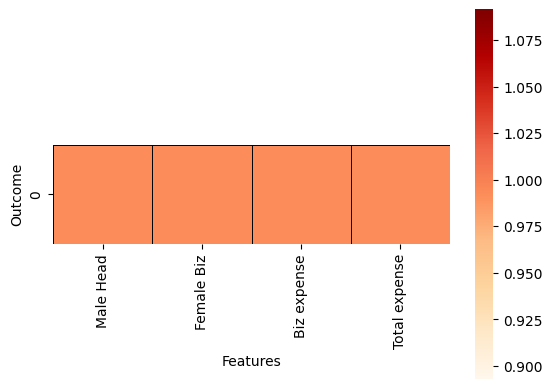

In [131]:

sns.heatmap(
    # feature_splits[:, :-1],
    feature_splits[0, 1:] / np.array([[2, 2, 2, 2]]),
    cmap="OrRd",
    # norm=colors.LogNorm(),
    linewidths=0.5,
    linecolor="black",
    annot=False,
    square=True
)


plt.xlabel("Features")
plt.ylabel("Outcome")

# plt.yticks(np.arange(0, len(outcome_fnames)) + 0.5, outcome_names, rotation=0)

plt.xticks(np.arange(0, len(features)-1)+0.5, features[1:], rotation=90)

# plt.title("Feature heterogeneity")

plt.show()

In [71]:
# active_profiles_idx = [51, 53, 55, 63] ##, 31]
active_profiles_idx = [16, 17, 29, 31]
# profile_labels = ["Male Head, Female Biz", "Durable Index", "Total expense", "Expense + Durable", "All"]
profile_labels = ["Durable Index", "Total expense", "Expense + Durable", "All"]

In [106]:
num_possible_splits = []
for profile in profiles:
    m = np.sum(profile[1:])
    num_possible_splits.append(2*m)

profile_splits[0, 16:] / num_possible_splits[16:]

/var/folders/ds/v36htzx10pv39ydvb7plxs1r0000gn/T/ipykernel_43517/3730962141.py:6: RuntimeWarning: invalid value encountered in divide
  profile_splits[0, 16:] / num_possible_splits[16:]


array([       nan, 1.25      , 0.        , 1.125     , 0.        ,
       1.125     , 0.        , 1.08333333, 0.        , 1.125     ,
       0.        , 1.08333333, 0.        , 1.08333333, 0.        ,
       1.0625    ])

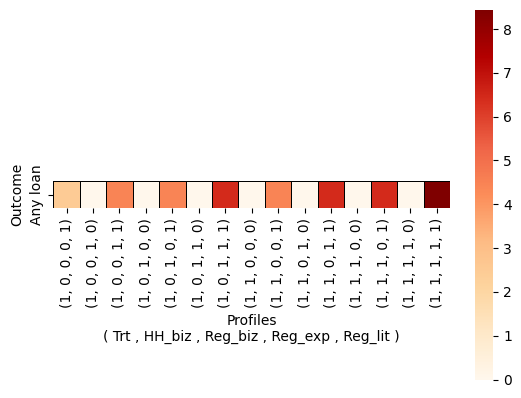

In [132]:


sns.heatmap(
    # profile_splits[:, active_profiles_idx],
    # profile_splits[0, active_profiles_idx] / np.array([[1, 4, 6, 8]]),
    [profile_splits[0, 17:]],
    # profile_splits[0, 17:] / np.array([num_possible_splits[17:]]),
    cmap="OrRd",
    # norm=colors.LogNorm(),
    linewidths=0.5,
    linecolor="black",
    annot=False,
    square=True
)


plt.xlabel("Profiles\n( Trt , HH_biz , Reg_biz , Reg_exp , Reg_lit )")
plt.ylabel("Outcome")

# plt.xticks(np.arange(0, len(active_profiles_idx)) + 0.5, profile_labels, rotation=90)
plt.xticks(np.arange(0, 15)+0.5, profiles[17:], rotation=90)
plt.yticks([0.5], ["Any loan"])

# plt.yticks(np.arange(0, len(outcome_fnames)) + 0.5, outcome_names, rotation=0)

# plt.title("Heterogeneity")


plt.show()